# Assignment 3
## Training a neural named entity recognition (NER) tagger 

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/): 

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:  

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


As always, make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.
<br>
<br>  

---

<br>

All additional packages:

In [ ]:
# !pip install --q
!pip install --q wget

All imports:
(You may add/change)

In [ ]:
# general
import os
import copy
import random
import warnings
from typing import List,Tuple
from collections import defaultdict


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# misc
import wget
import zipfile


set warnings filter to ignore:

In [ ]:
warnings.filterwarnings('ignore')

Set random SEEDs:

In [ ]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Set GPU:

In [ ]:
# make sure you're using a GPU

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Task 1:
Write a function for reading the data from a single file (of the ones that are provided above).   
- The function recieves a filepath 
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. 
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [ ]:
def read_data(filepath:str) -> List[Tuple[List[str],List[str]]]:
    data = []

    filename = filepath.split('/')[-1]
    wget.download(filepath)

    with open(filename, 'r') as f:
      lines = f.readlines()

    for record in split(lines, '\n'): # record is a list of a single sentence
      if len(record) == 0:
        continue

      entries = list(map(lambda s: s.split(' '), record))
      words = [entry[0] for entry in entries]
      tags = [entry[1] for entry in entries]

      data.append((words, tags))

    return data


def split(sequence, sep):
    '''
    Generator function that gets a list and yields sub-lists by a given seperator.
    For example:
    [a, SEP, b, c, SEP, SEP, d] -> [[a], [b, c], [], [d]]
    '''
    chunk = []
    for val in sequence:
        if val == sep:
            yield chunk
            chunk = []
        else:
            chunk.append(val)
    yield chunk

# GitHub
train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

# Google-Drive
# train_link = 'https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing'
# dev_link   = 'https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing'
# test_link  = 'https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing'


train = read_data(train_link)
dev = read_data(dev_link)
test = read_data(test_link)

# debug
#print(train[0:4])

## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.   
The UNK_TOKEN should be used for words that are not part of the training data.

Note: you may change the Vocab class

In [ ]:
UNK_TOKEN = 1
PAD_TOKEN = 0
MAX_SEQ_LENGTH = 60

class Vocab:
    def __init__(self,train:List[Tuple[List[str],List[str]]]):
        self.word2id = { "__pad__": PAD_TOKEN, "__unk__": UNK_TOKEN}
        self.id2word = ["__pad__", "__unk__"]
        self.n_words = 2

        self.tag2id = None
        self.id2tag = None

        words = set()
        tags = set()

        for data, label in train:
          words.update(data)
          tags.update(label)

        self.word2id.update({word : (id + 2) for id, word in enumerate(words)})
        self.id2word += list(words)
        self.n_words = len(self.id2word)

        self.tag2id = {tag : id for id, tag in enumerate(tags)}
        self.id2tag = list(tags)

    def index_tags(self, tags:List[str]) -> List[int]:
      tag_indexes = [self.tag2id[t] for t in tags]
      return tag_indexes

    def ids_to_tags(self, ids:List[int]) -> List[str]:
      return [self.id2tag[int(id)] for id in ids]

    def index_words(self, words:List[str]) -> List[int]:
      word_indexes = [self.word2id.get(w, UNK_TOKEN) for w in words]
      return word_indexes

    def ids_to_words(self, ids:List[int]) -> List[str]:
      return [self.id2word[int(id)] for id in ids]

# Testing - do not change
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()
del vcb


Write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.  

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [ ]:
def prepare_data(data, _vocab=None):
    data_sequences = []
    vocab = Vocab(data) if _vocab is None else _vocab

    for sentence, tags in data:
      word_indices = vocab.index_words(sentence)
      word_indices += [PAD_TOKEN] * max(0, MAX_SEQ_LENGTH - len(word_indices))
      tag_indices = vocab.index_tags(tags)
      tag_indices += [PAD_TOKEN] * max(0, MAX_SEQ_LENGTH - len(tag_indices))

      data_sequences.append((word_indices, tag_indices))

    if _vocab:
      return data_sequences
    else:
      return data_sequences, vocab

train_sequences, vocab = prepare_data(train)
dev_sequences = prepare_data(dev, vocab)
test_sequences = prepare_data(test, vocab)

Print: how many OOV words are in the dev dataset? 

In [ ]:
def count_oov(dataset, vocab):
    words = set()
    for sentence, _ in dataset:
      words.update(sentence)

    # get indices and count how many got the __unk__ index
    return vocab.index_words(list(words)).count(UNK_TOKEN)

print(f'There are {count_oov(dev, vocab)} OOV words are in the dev dataset')

There are 607 OOV words are in the dev dataset


Print: how many OOV words are in the test dataset? 

In [ ]:
print(f'There are {count_oov(test, vocab)} OOV words are in the test dataset')

There are 1263 OOV words are in the test dataset


## Task 3:

Write NERNet, a PyTorch Module for labeling words with NER tags. 

> `input_size`: the size of the vocabulary  
`embedding_size`: the size of the embeddings  
`hidden_size`: the LSTM hidden size  
`output_size`: the number tags we are predicting for  
`n_layers`: the number of layers we want to use in LSTM  
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively  

<br>  

The input for your forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embedding. That means that you don't need to use pretrained embedding like the one used in class. You will use them in part 5.*

*Note: You may change the NERNet class.* 

In [ ]:
# You may change the NERNet class.

class NERNet(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, output_size, n_layers, directions):
        super(NERNet, self).__init__()
        self.vocab = vocab
        self.classes = output_size
        self.embedding = nn.Embedding(num_embeddings=vocab.n_words, embedding_dim=embedding_size, padding_idx=PAD_TOKEN)
        self.embedding.weight.data[PAD_TOKEN] = torch.zeros(embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, bidirectional=(directions == 2), batch_first=True)
        self.out = nn.Linear(hidden_size * directions, self.classes)
    
    def forward(self, input_sentence):
        embeds = self.embedding(input_sentence)
        lstm_out, _ = self.lstm(embeds)
        return self.out(lstm_out)

    def init_weights(self, pretrained_weight=None):
      if pretrained_weight is not None:
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weight))


embedding_size = 50  
hidden_size = 128  
output_size = 7  
n_layers = 2  
directions = 1  

model = NERNet(vocab, embedding_size, hidden_size, output_size, n_layers, directions)   
print(model)

NERNet(
  (embedding): Embedding(7163, 50, padding_idx=0)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True)
  (out): Linear(in_features=128, out_features=7, bias=True)
)




```
# This is formatted as code
```

Create a Dataloader for the training phase

In [ ]:
def prepare_data_loader(sequences, batch_size=64, suffle=True):
    class CustomNerDataset(Dataset):
        def __init__(self, sequences):
            self.sequences = sequences

        def __len__(self):
            return len(self.sequences)

        def __getitem__(self, idx):
            data, label = self.sequences[idx]
            return torch.IntTensor(data), torch.LongTensor(label)

    dataloader = DataLoader(CustomNerDataset(sequences), batch_size=batch_size, shuffle=suffle, drop_last=True)
    return dataloader

dl_train  = prepare_data_loader(train_sequences , batch_size = 64)
dl_dev    = prepare_data_loader(dev_sequences   , batch_size = 64)
dl_test   = prepare_data_loader(test_sequences  , batch_size = 64)

## Task 4:

Write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.  

The function will return the `loss` and `accuracy` durring training.  
(If you're using a different/additional metrics, return them too)

The loss is always CrossEntropyLoss and the optimizer is always Adam.
Make sure to use `tqdm` while iterating on `n_epochs`.


In [ ]:
def train_loop(model, n_epochs, dataloader_train, dataloader_dev):
  
  # Loss function
  criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

  # Optimizer (ADAM is a fancy version of SGD)
  optimizer = Adam(model.parameters(), lr=0.001)

  # record
  metrics = {'loss':{'train':[], 'dev':[]}, 'accuracy':{'train':[], 'dev':[]} }
  model_on_device = model.to(DEVICE)
  
  for epoch in tqdm(range(n_epochs)):
      train_loss = 0.0
      train_correct = 0.0
      train_total = 0.0
      model_on_device.train()
      for data, labels in dataloader_train:
          data, labels = data.to(DEVICE), labels.to(device=DEVICE)
          
          optimizer.zero_grad()
          target = model_on_device(data)
          target = target.view(-1, target.shape[-1])
          labels = labels.view(-1)
          loss = criterion(target, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

          mask = (labels != PAD_TOKEN).view(-1)
          _, target = torch.max(target, 1)
          train_correct += target[mask].eq(labels[mask]).sum().item()
          train_total += mask.sum().item()
      
      validation_loss = 0.0
      validation_correct = 0.0
      validation_total = 0.0
      model_on_device.eval()     # Optional when not using Model Specific layer
      for data, labels in dataloader_dev:
          data, labels = data.to(DEVICE), labels.to(device=DEVICE)
          
          with torch.no_grad():
              target = model_on_device(data)
              target = target.view(-1, target.shape[-1])
              labels = labels.view(-1)
              loss = criterion(target, labels)
              validation_loss += loss.item()

          mask = (labels != PAD_TOKEN).view(-1)
          _, target = torch.max(target, 1)
          validation_correct += target[mask].eq(labels[mask]).sum().item()
          validation_total += mask.sum().item()
      
      metrics['loss']['train'].append(train_loss)
      metrics['accuracy']['train'].append(train_correct / train_total)
      metrics['loss']['dev'].append(validation_loss)
      metrics['accuracy']['dev'].append(validation_correct / validation_total)

  return metrics


metrics = train_loop(model, 10, dl_train, dl_dev)
print(metrics)

100%|██████████| 10/10 [00:01<00:00,  5.53it/s]

{'loss': {'train': [32.18903422355652, 19.674470841884613, 18.93423318862915, 18.258957266807556, 17.31995666027069, 16.057826161384583, 14.47492316365242, 13.045724153518677, 11.629681408405304, 10.513748973608017], 'dev': [2.378538131713867, 2.3093621730804443, 2.1365082263946533, 2.0476653575897217, 2.075155258178711, 1.8664060831069946, 1.7007810473442078, 1.653717190027237, 1.529344081878662, 1.38785320520401]}, 'accuracy': {'train': [0.735832083958021, 0.8316481864311219, 0.8325263671508464, 0.832372754491018, 0.8317451980792316, 0.8327696354753852, 0.8430217285247871, 0.8507624864176252, 0.8597076461769115, 0.8673297053856258], 'dev': [0.8300653594771242, 0.8210564139417894, 0.8338028169014085, 0.8299295774647887, 0.8160412067696836, 0.8295081967213115, 0.8422659430122117, 0.8488491927172793, 0.8556094182825484, 0.8629799225079253]}}


<br><br><br><br><br><br>

## Task 5:
Write an evaluation loop on a trained model, using the dev and test datasets.   
This function will print a `RECALL-PERCISION-F1` scores and plot a `confusion matrix`.  

Do this twice: once for all the labels (7 labels in total), and once for all the labels except O (6 labels in total).   





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic average
- *For all these metries use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

To display:
1. Print a `RECALL-PERCISION-F1` scores in a `tabulate` format (similar to assignment#2)
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.


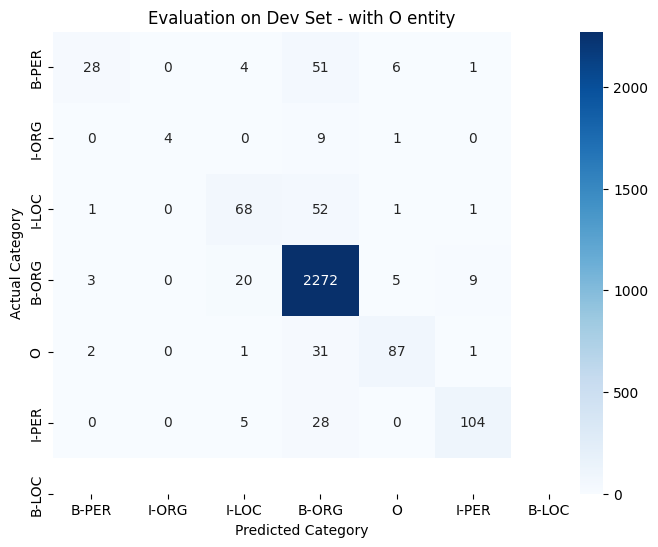

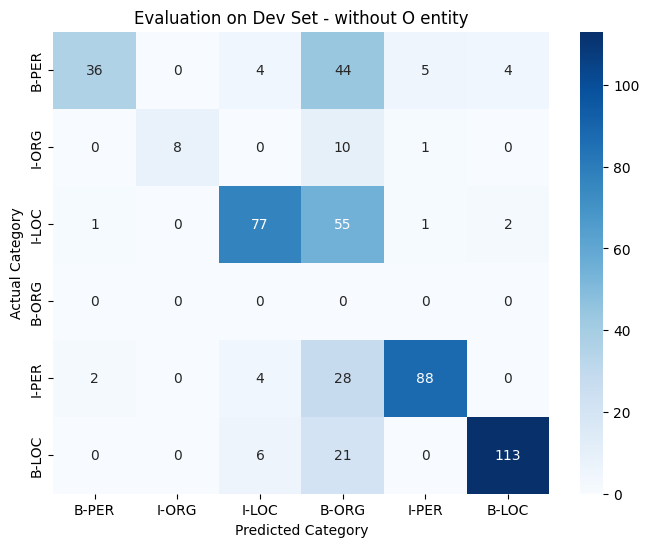

+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
| model     |           128 |          2 |            1 | 0.916995 |    0.912276 | 0.908317 |      0.631373 |          0.91348 |  0.736005 |
+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+


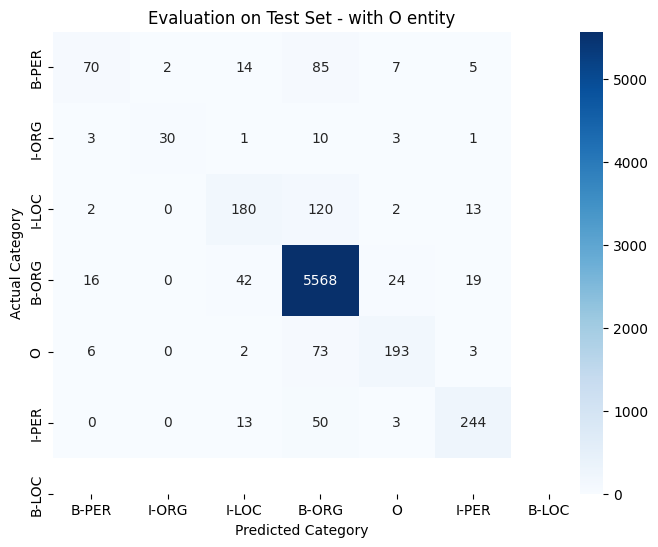

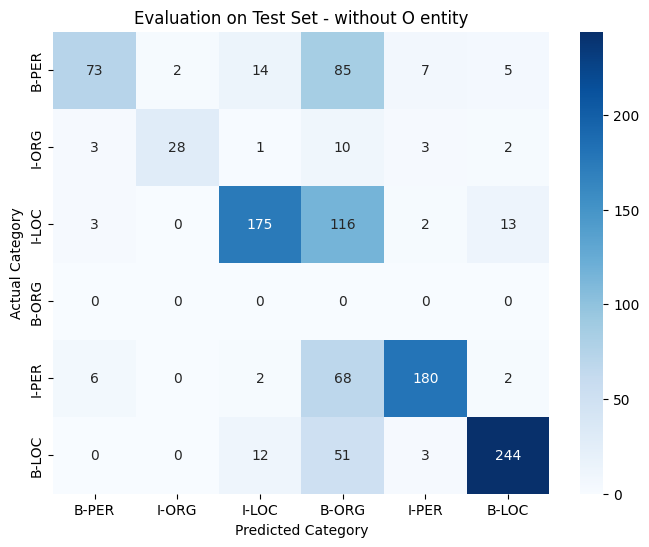

+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------|
| model     |           128 |          2 |            1 | 0.923721 |     0.91768 | 0.918044 |      0.630631 |         0.892969 |  0.732324 |
+-----------+---------------+------------+--------------+----------+-------------+----------+---------------+------------------+-----------+


In [ ]:
def evaluate(model, title, dataloader):
    precision, recall, fscore = evaluate_inner(model, title + ' - with O entity', dataloader)
    precision_wo_o, recall_wo_o, fscore_wo_o = evaluate_inner(model, title + ' - without O entity', dataloader, with_o=False)
    all_data = [['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O'], \
                ['model', hidden_size, n_layers, directions, recall, precision, fscore, recall_wo_o, precision_wo_o, fscore_wo_o]]
    print(tabulate(all_data,headers='firstrow',tablefmt='psql'))

def evaluate_inner(model, title, dataloader, with_o=True, display_cm=True): 
    model_on_device = model.to(DEVICE)
    model_on_device.eval()

    preds = torch.empty(0).to(DEVICE)
    gt = torch.empty(0).to(DEVICE)

    # all classes
    for data, labels in dataloader:
      data, labels = data.to(DEVICE), labels.to(device=DEVICE)
          
      with torch.no_grad():
          target = model_on_device(data)
          _, target = torch.max(target, 2)
          target = target.view(-1)
          labels = labels.view(-1)


      if with_o:
        mask = (labels != PAD_TOKEN).view(-1)
        label_names = model.vocab.tag2id
      else:
        mask = torch.logical_and((labels != PAD_TOKEN).view(-1), (labels != model.vocab.tag2id['O']))
        label_names = list(filter(lambda tag: tag != 'O',model.vocab.tag2id))

      preds = torch.cat((target[mask], preds))
      gt = torch.cat((labels[mask], gt))

    gt = gt.cpu()
    preds = preds.cpu()
    precision, recall, fscore, _ = precision_recall_fscore_support(gt.numpy(), preds.numpy(), average='weighted')

    if display_cm:
      cm = confusion_matrix(gt, preds)

      fig, ax = plt.subplots(1,1,figsize=(8,6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
      plt.ylabel('Actual Category')
      plt.xlabel('Predicted Category')

      plt.title(title)

      plt.show()
    return precision, recall, fscore

# Example usage
evaluate(model, "Evaluation on Dev Set", dl_dev)
evaluate(model, "Evaluation on Test Set", dl_test)

Note: look at part 6 for an example.
<br><br><br><br><br>

## Part 6



Reset all seeds to 42.

In [ ]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters (you may use that as captions for the models as well):

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




In [ ]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
models = {
    'Model1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}


results = [columns]

for model_name, params in models.items():
  results_row = [model_name, params['hidden_size'], params['n_layers'], params['directions']]

  model = NERNet(vocab, params['embedding_size'], params['hidden_size'], 7, params['n_layers'], params['directions'])
  train_loop(model, 30, dl_train, dl_dev)

  precision, recall, fscore = evaluate_inner(model, '', dl_test, display_cm=False)
  precision_wo_o, recall_wo_o, fscore_wo_o = evaluate_inner(model, '', dl_test, with_o=False, display_cm=False)

  results_row.extend([recall, fscore, precision, recall_wo_o, fscore_wo_o, precision_wo_o])
  results.append(results_row)

print(tabulate(results,headers='firstrow',tablefmt='psql',floatfmt=".4f"))

100%|██████████| 30/30 [04:18<00:00,  8.62s/it]


+-----------+---------------+------------+--------------+----------+-------------+--------+---------------+------------------+-----------+
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |     F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------+---------------+------------+--------------+----------+-------------+--------+---------------+------------------+-----------|
| Model1    |           500 |          1 |            1 |   0.9123 |      0.9099 | 0.9135 |        0.6655 |           0.7382 |    0.8700 |
| Model2    |           500 |          2 |            1 |   0.9260 |      0.9208 | 0.9202 |        0.6240 |           0.7285 |    0.8919 |
| Model3    |           500 |          3 |            1 |   0.9119 |      0.8981 | 0.9081 |        0.4699 |           0.6064 |    0.9013 |
| Model4    |           500 |          1 |            2 |   0.9280 |      0.9237 | 0.9250 |        0.6349 |           0.7342 |    0.8877 |
| Model5    |           500

**Save CSV**  
In addition, for each model use the `test` dataset and check the model metrics. 

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries use **weighted** ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

> - Save the results in a CSV
`{student_id_1}_{student_id_n}_part6.csv`    
For example: `300123123_200456789_part_6.csv`

> - Print the results as follows:  (results here are random)

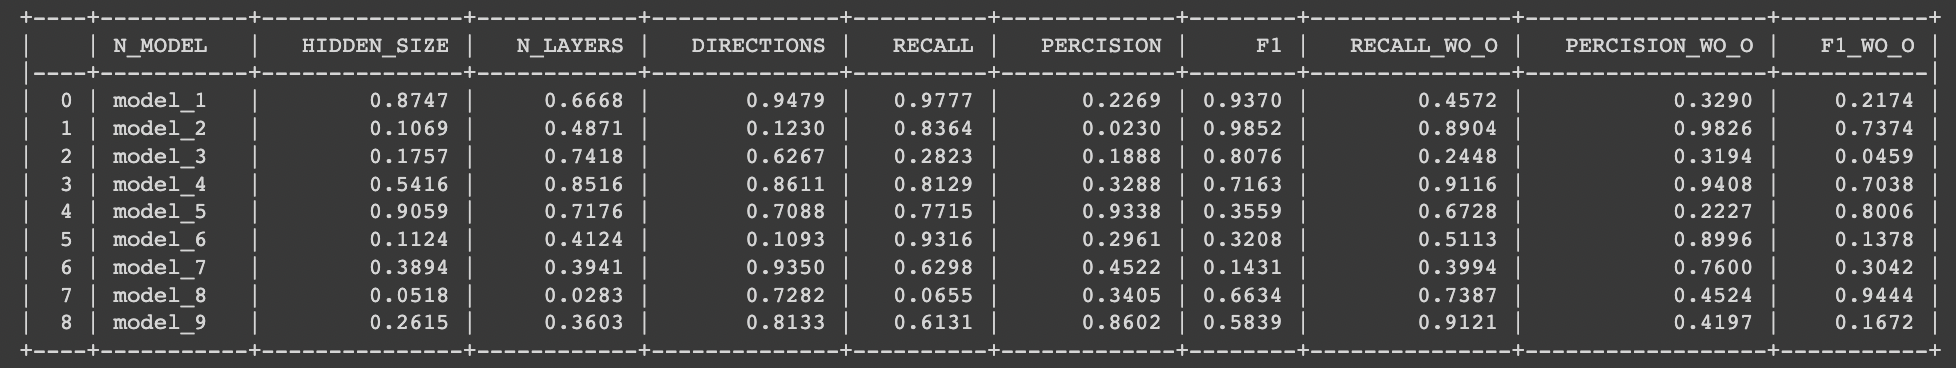

In [ ]:
# TO DO - save csv
df = pd.DataFrame(results[1:], columns = results[0])
part6_filename = '319122610_206446221_part_6.csv'
df.to_csv(part6_filename)

<br><br><br><br><br>

## Task 7: 

Reset all seeds to 42.

In [ ]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


In preparation for this task you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: make sure that vectors are aligned with the IDs in your Vocab, in other words, make sure that for example the word with ID 0 is the first vector in the GloVe matrix of vectors that you initialize nn.Embedding with.*

---


Download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip). 


In [ ]:
wget.download('https://nlp.stanford.edu/data/glove.6B.zip')

'glove.6B.zip'

Then intialize the `nn.Embedding` module in your `NERNet` with these embeddings, so that you can start your training with pre-trained vectors. 

In [ ]:
# 1. open the glove embedding zip file and extract the releveant file
with zipfile.ZipFile('glove.6B.zip', 'r') as zip:
    zip.extract('glove.6B.300d.txt')

glove_weights = np.zeros((vocab.n_words, 300))

# 2. for each word in our vocab with index i in the dict :
#    add to the ith row of glove_weights the vector corresponding to that word
with open('glove.6B.300d.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
      values = line.split(' ')
      if values[0] in vocab.word2id:
        id = vocab.word2id[values[0]]
        glove_weights[id] = np.array(values[1:])


Repeat `Task 6`

100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


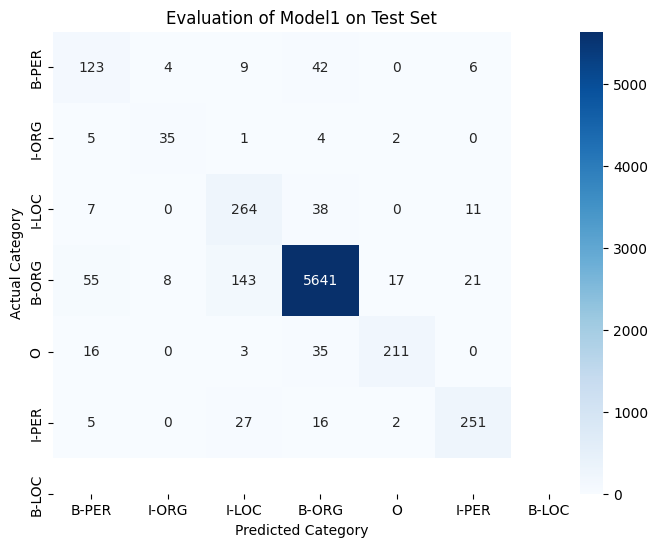

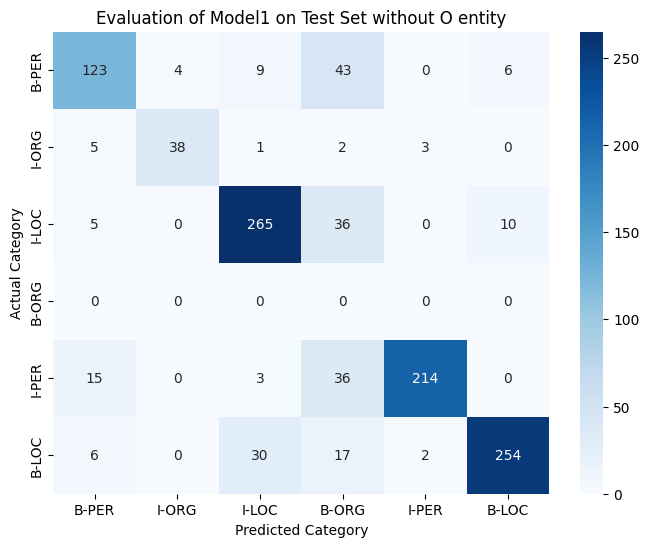

100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


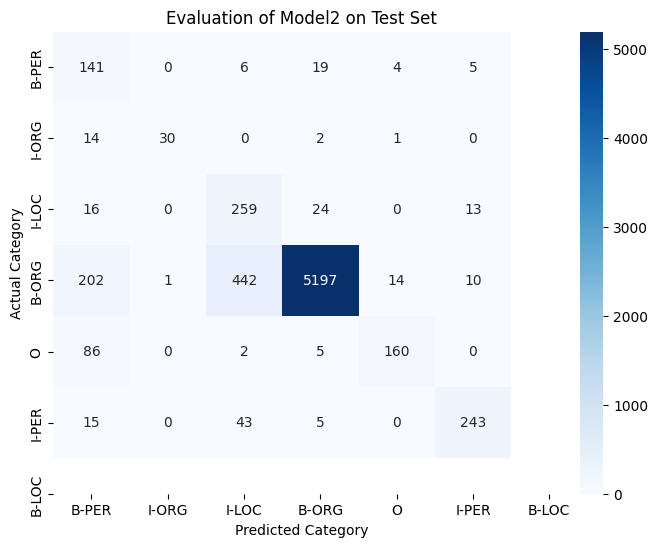

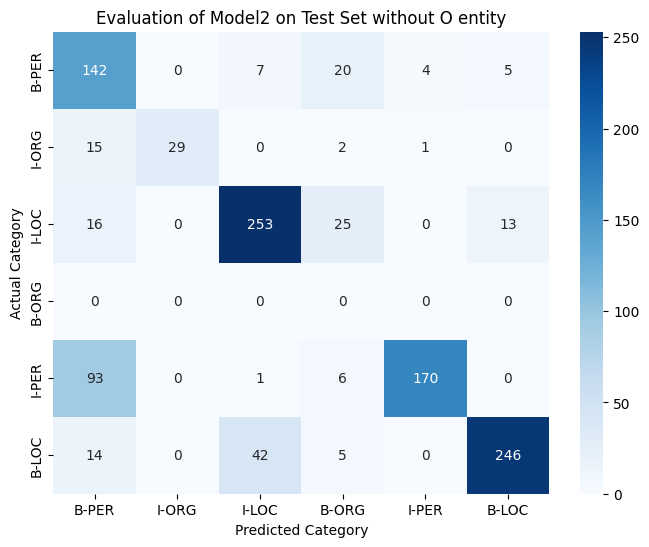

100%|██████████| 30/30 [00:41<00:00,  1.38s/it]


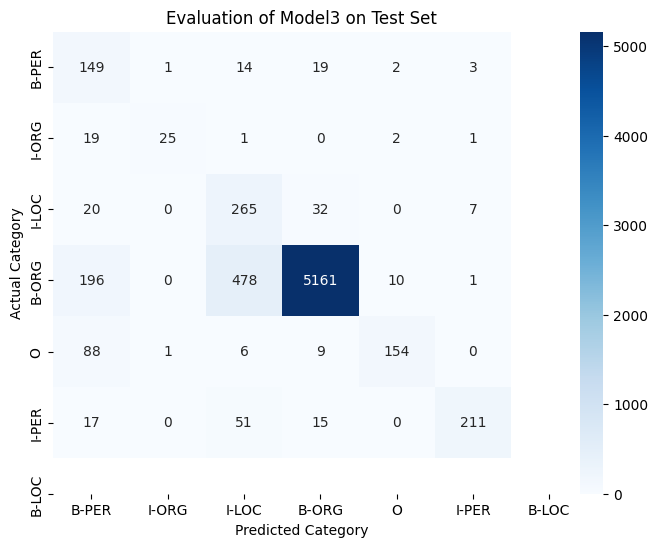

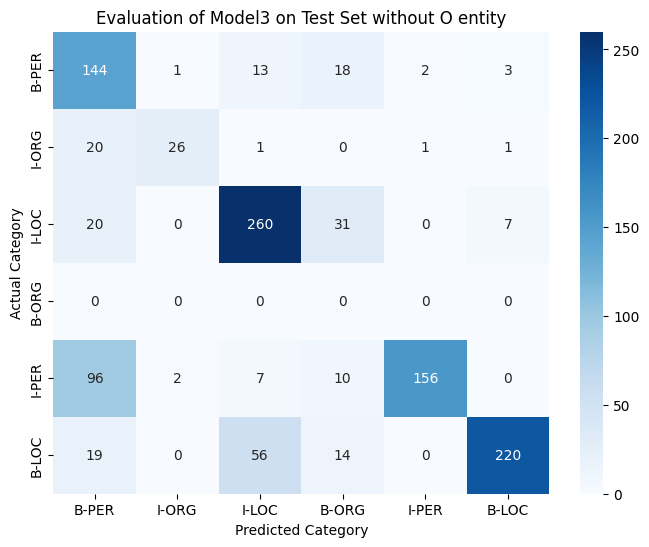

100%|██████████| 30/30 [00:26<00:00,  1.13it/s]


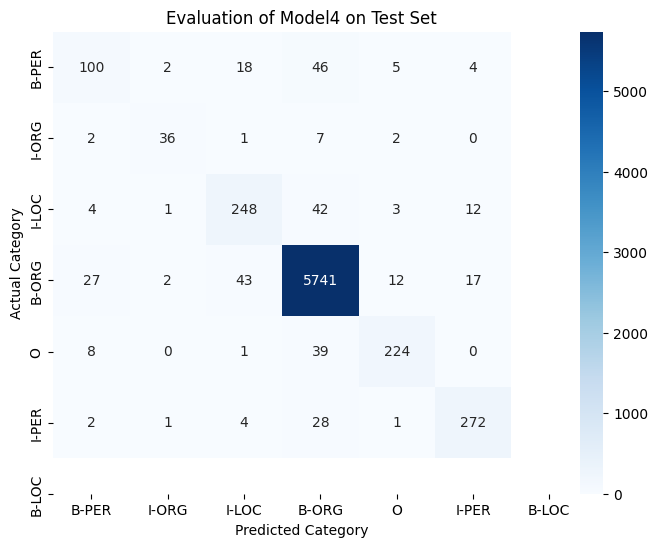

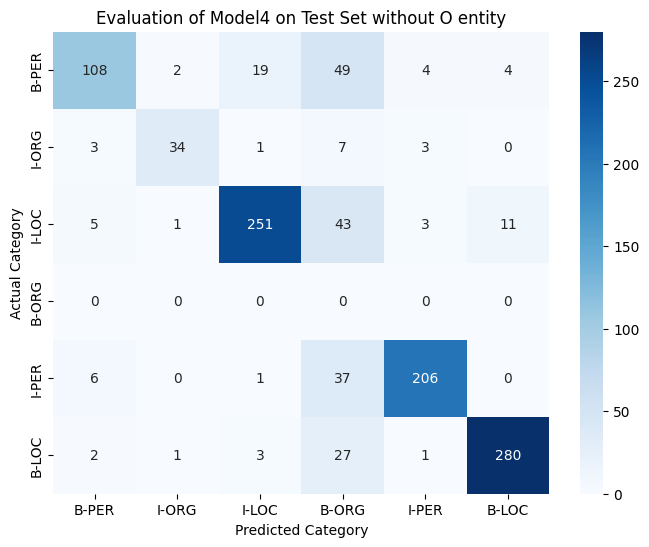

100%|██████████| 30/30 [01:08<00:00,  2.27s/it]


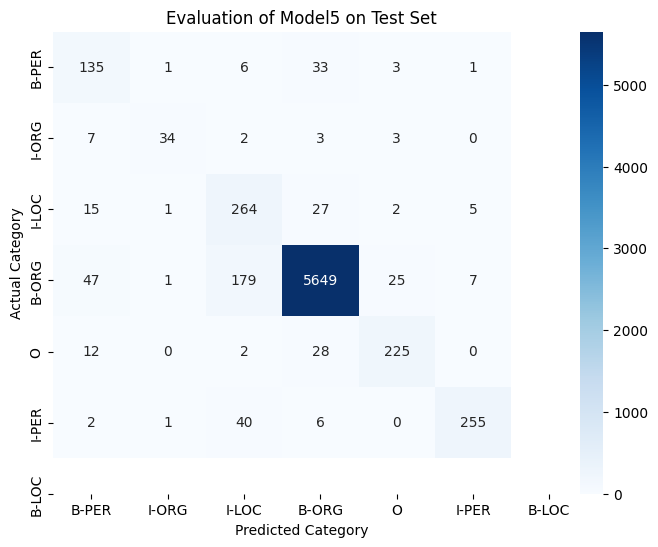

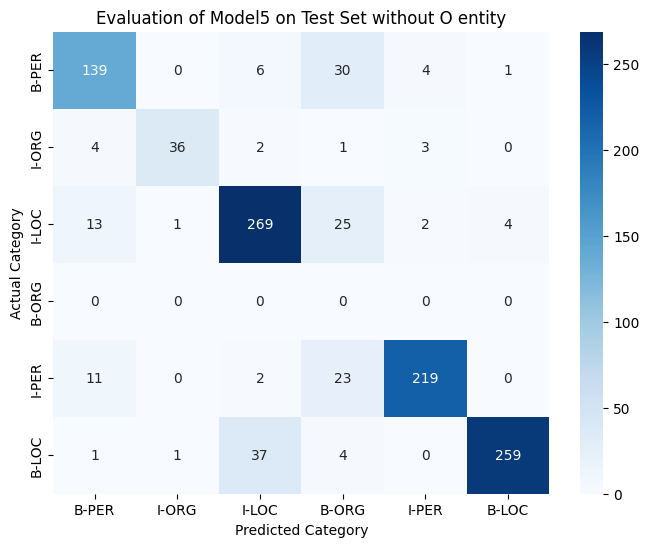

100%|██████████| 30/30 [01:53<00:00,  3.77s/it]


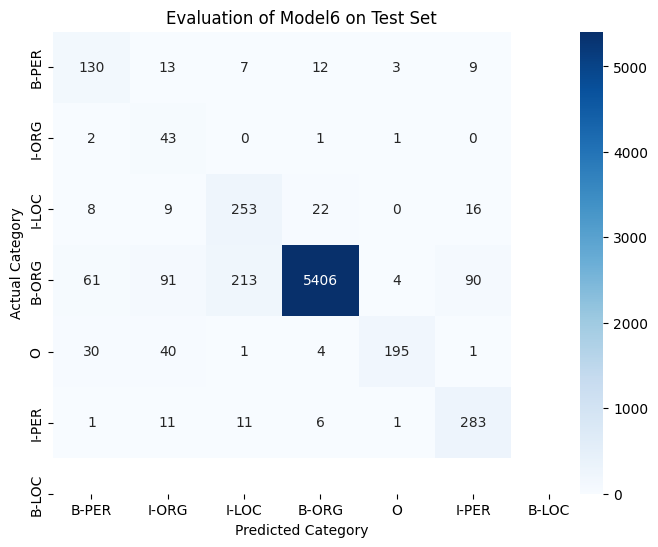

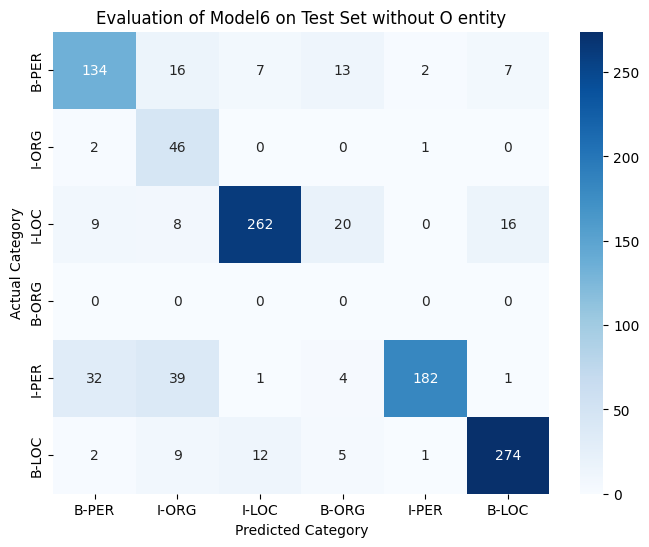

100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


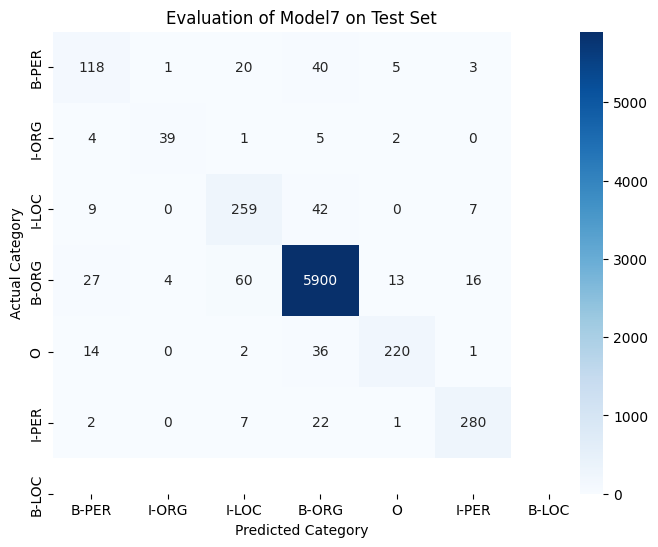

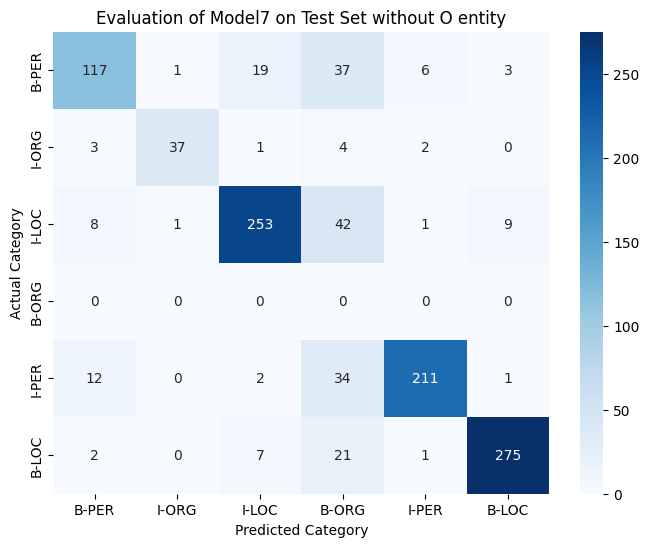

100%|██████████| 30/30 [02:34<00:00,  5.15s/it]


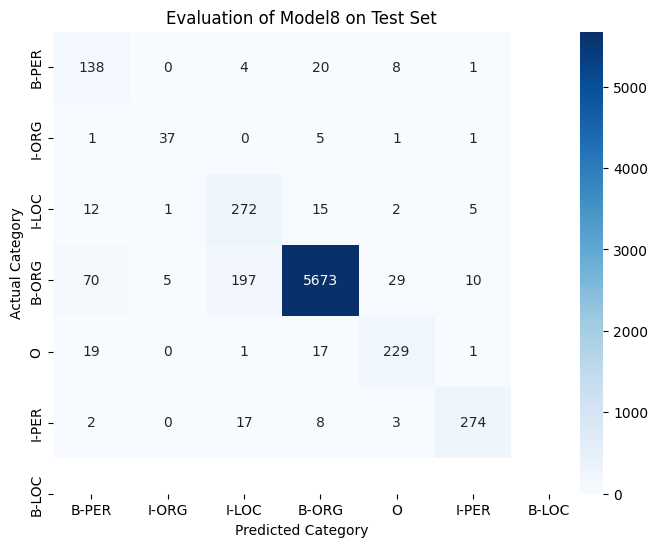

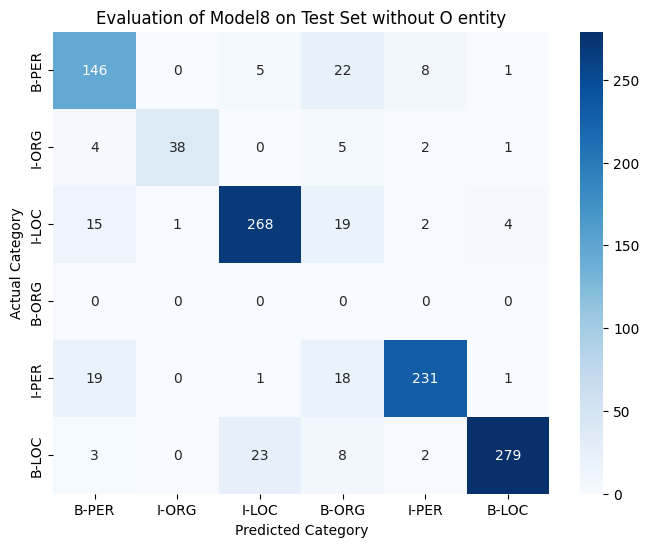

100%|██████████| 30/30 [04:18<00:00,  8.60s/it]


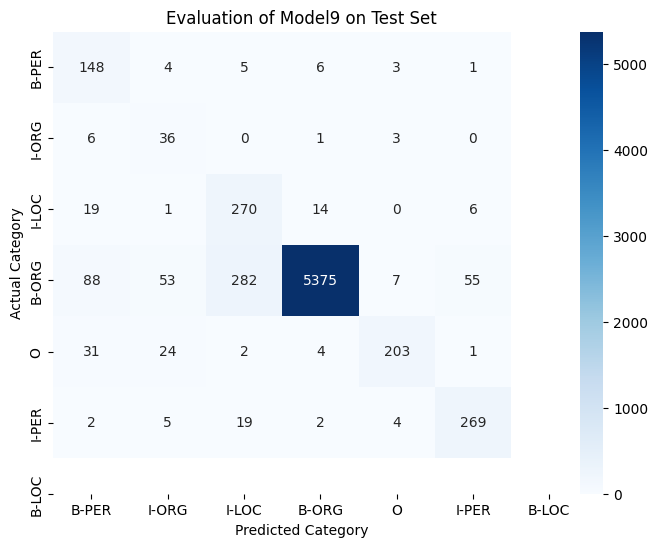

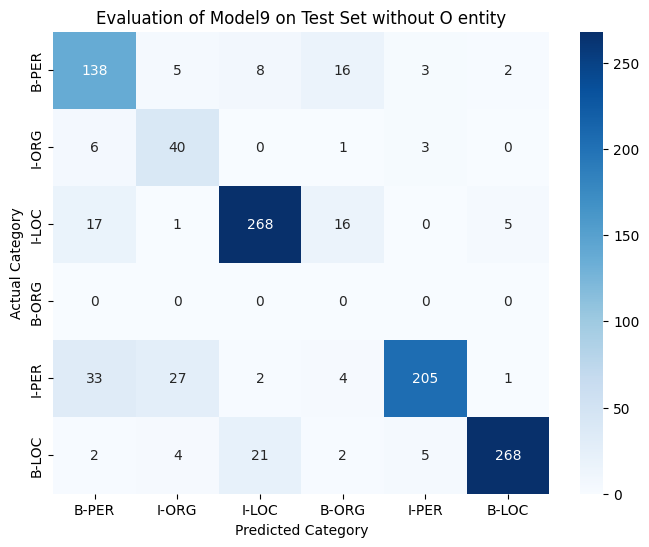

In [ ]:
results_glove = [columns]
trained_models = []

for model_name, params in models.items():
  results_row = [model_name, params['hidden_size'], params['n_layers'], params['directions']]

  model = NERNet(vocab, params['embedding_size'], params['hidden_size'], 7, params['n_layers'], params['directions'])
  model.init_weights(glove_weights)
  train_loop(model, 30, dl_train, dl_dev)

  precision, recall, fscore = evaluate_inner(model, f"Evaluation of {model_name} on Test Set", dl_test)
  precision_wo_o, recall_wo_o, fscore_wo_o = evaluate_inner(model, f"Evaluation of {model_name} on Test Set without O entity", dl_test, with_o=False)

  results_row.extend([recall, fscore, precision, recall_wo_o, fscore_wo_o, precision_wo_o])
  results_glove.append(results_row)



Same as `Task 6`, please display:

1. Print a `RECALL-PERCISION-F1` scores in a tabulate format.
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.

In [ ]:
# TO DO - save csv
df_glove = pd.DataFrame(results_glove[1:], columns = results_glove[0])
part7_filename = '319122610_206446221_part_7.csv'
df_glove.to_csv(part7_filename)

- Save the results in a CSV {student_id_1}_{student_id_n}_part7.csv  
For example: 300123123_200456789_part_7.csv

- Print the results as follows:

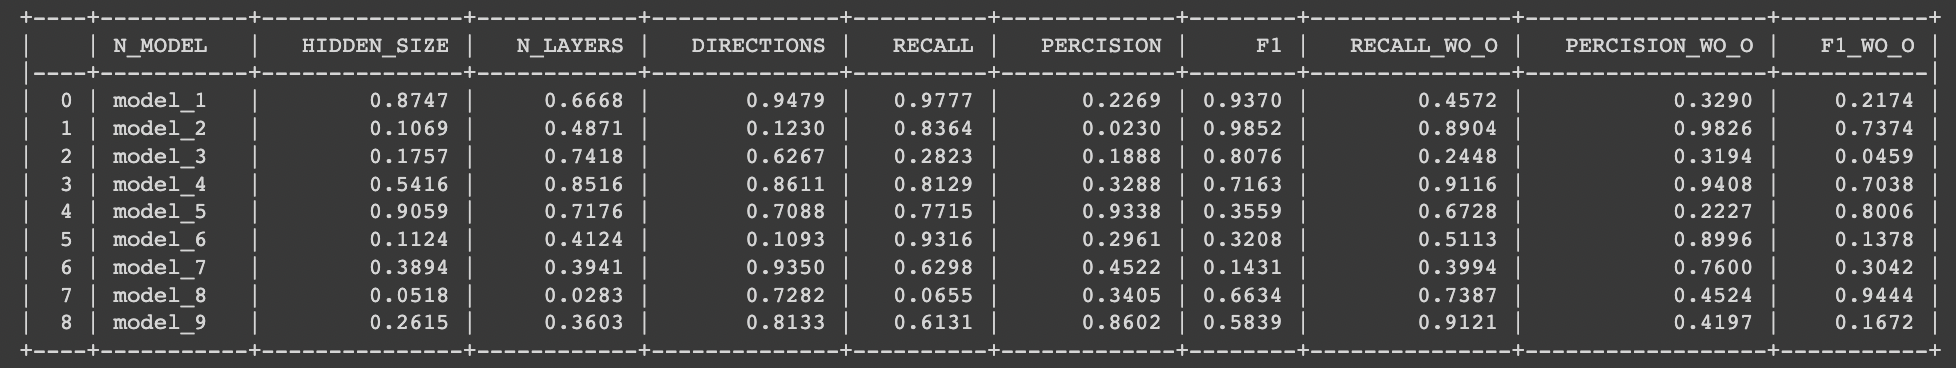

In [ ]:
print(tabulate(results_glove,headers='firstrow',tablefmt='psql',floatfmt=".4f"))

+-----------+---------------+------------+--------------+----------+-------------+--------+---------------+------------------+-----------+
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |     F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------+---------------+------------+--------------+----------+-------------+--------+---------------+------------------+-----------|
| Model1    |           500 |          1 |            1 |   0.9319 |      0.9347 | 0.9399 |        0.7933 |           0.8431 |    0.9020 |
| Model2    |           500 |          2 |            1 |   0.8665 |      0.8900 | 0.9355 |        0.7574 |           0.7860 |    0.8494 |
| Model3    |           500 |          3 |            1 |   0.8573 |      0.8820 | 0.9319 |        0.7145 |           0.7466 |    0.8303 |
| Model4    |           500 |          1 |            2 |   0.9520 |      0.9509 | 0.9505 |        0.7905 |           0.8493 |    0.9235 |
| Model5    |           500

<br><br><br><br><br><br>
**Good luck!**